# LactationCurve Tutorial (pip Installation Version)

This tutorial is for users who installed the package locally using:

```bash
pip install lactationcurve
```

and then import it in Python using:

```python
from lactationcurve import ...
```

### What you will learn 
- how to use the imported functions of the package to fit a lactationcurve 
- how to fit a lactationcurve using Bayesian statistics 
- how to calculate lactation curve characteristics 
- how to apply the test interval method to calculate cumulative milk yield
- how to use the help() function to explain a function 


## Import the Package

In [61]:
# Import core functionality
from lactationcurve import fit_lactation_curve, calculate_characteristic, test_interval_method, milkbot_model, dijkstra_model, lactation_curve_characteristic_function

#import the other libraries we will need for this tutorial 
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

## Load Sample Data

We will take 9 milk samples at random days in milk (dim) of a typical Holstein lactation 


In [ ]:
# Sample test-day data: 9 recordings across a 305-day lactation
sample_data = {
    "dim": [10, 30, 60, 90, 120, 150, 200, 250, 305],
    "milkrecordings": [15.0, 25.0, 30.0, 28.0, 26.0, 24.0, 22.0, 20.0, 18.0],
}

#create a panda dataframe
sample_df = pd.DataFrame(sample_data)

# Extract DIM (days in milk) and milk recordings
dim = sample_data["dim"]
milk_recording = sample_data["milkrecordings"]


## Fit a Lactation Curve (Frequentist)

We want to fit the measured milk yields to a lactation curve model and visualize the results. For this we will use traditional frequentist statistics.


In [14]:
fit = fit_lactation_curve(dim, milk_recording, model="milkbot")

# Display the fitted values
print(f"Number of predicted values: {len(fit)}")
print(f"First 10 predictions (DIM 1-10): {fit[:10]}")

Number of predicted values: 305
First 10 predictions (DIM 1-10): [ 4.29486475  5.74513253  7.11819775  8.41798242  9.6482097  10.81241397
 11.91395044 12.95600419 13.94159879 14.87360454]


#### Plot the fitted curve

Let's visualize the fitted curve alongside the original test-day recordings.

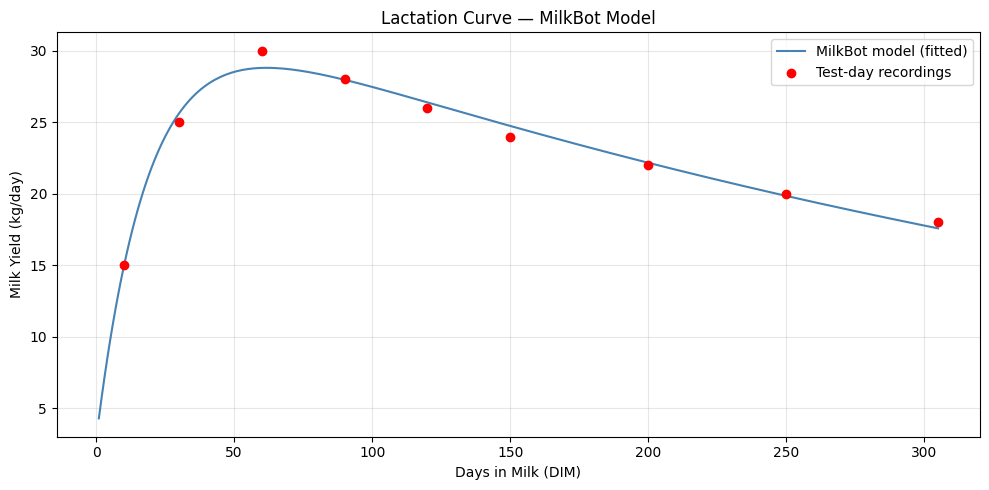

In [16]:
dim_predicted = list(range(1, len(fit) + 1))

plt.figure(figsize=(10, 5))
plt.plot(dim_predicted, fit, label="MilkBot model (fitted)", color="steelblue")
plt.scatter(
    sample_data["dim"],
    sample_data["milkrecordings"],
    color="red",
    zorder=5,
    label="Test-day recordings",
)
plt.xlabel("Days in Milk (DIM)")
plt.ylabel("Milk Yield (kg/day)")
plt.title("Lactation Curve — MilkBot Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Compare multiple models

Let's fit all five available models and compare them visually.

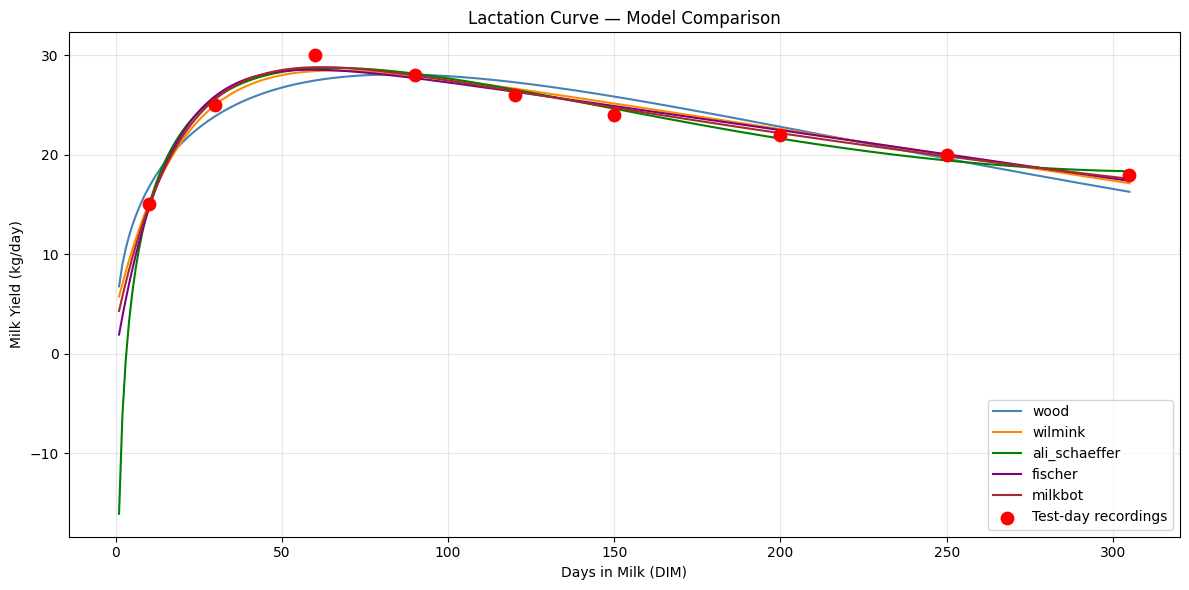

In [17]:
models = ["wood", "wilmink", "ali_schaeffer", "fischer", "milkbot"]
colors = ["steelblue", "darkorange", "green", "purple", "brown"]

plt.figure(figsize=(12, 6))

for model_name, color in zip(models, colors):
    fit = fit_lactation_curve(dim, milk_recording, model=model_name)
    plt.plot(range(1, len(fit) + 1), fit, label=model_name, color=color)

plt.scatter(
    sample_data["dim"],
    sample_data["milkrecordings"],
    color="red",
    zorder=5,
    s=80,
    label="Test-day recordings",
)
plt.xlabel("Days in Milk (DIM)")
plt.ylabel("Milk Yield (kg/day)")
plt.title("Lactation Curve — Model Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Bayesian Fitting (MilkBot API Key Required)

Bayesian fitting requires a MilkBot API key. The key can be requested by sending an email to Jim Ehrlich jehrlich@MilkBot.com.


### Step 1: Create a `.env` file to add the key to your data pipeline 

Use the provided `.env.example` template and create a `.env` file in your project directory:

```
milkbot_key= 'example000000'
```

### Step 2: Load the key in Python


In [2]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

def milkbot_key() -> str:
    """Return the MilkBot API key from environment."""
    key = os.getenv("milkbot_key")
    if not key:
        raise ValueError("milkbot_key not found in environment. Check your .env file.")
    return key

key = milkbot_key()


### Step 3: Run Bayesian Fitting

The fitting API works by converting the data into a json and sending it to an online fitting api. The creation of the json is completely taken care off by the function.
You only need to provide the key and set the fitting to bayesian to start using the API. As Bayesian statistics is dependent on priors you can add some metadata to the fitting function to tell the system which priors to use. Examples include adding parity information or add a continent where you collected your data. For more information on the fitting api look at https://api.milkbot.com/#section/MilkBot-Fitting. 

In [ ]:
# Fit the MilkBot model using Bayesian fitting method with data from an American cow

mb_bay_usa = fit_lactation_curve(
    dim,
    milk_recording,
    model="milkbot",
    fitting="bayesian",
    key=key
)

print(f"First 10 predictions (DIM 1-10): {mb_bay_usa[:10]}")


First 10 predictions (DIM 1-10): [17.56294114 18.0977176  18.61000852 19.10065584 19.57047022 20.02023212
 20.45069299 20.8625763  21.25657861 21.63337055]


Example for Europe, with a second parity cow. 

If you do not provide extra information the model will asume you have an American, third lactation cow from the Holstein breed.

In [ ]:
mb_bay_eu = fit_lactation_curve(
    dim,
    milk_recording,
    model="milkbot",
    fitting="bayesian",
    key=key,
    parity = 2,
    breed = 'H', # H = Holstein, J = Jersey 
    continent="EU"
)

print(f"First 10 predictions (DIM 1-10): {mb_bay_eu[:10]}")

First 10 predictions (DIM 1-10): [16.95154315 17.54254086 18.10487199 18.63981329 19.14858482 19.6323525
 20.09223049 20.52928348 20.94452892 21.33893906]


### Compare bayesian fitting to frequentist fitting by visualisation 

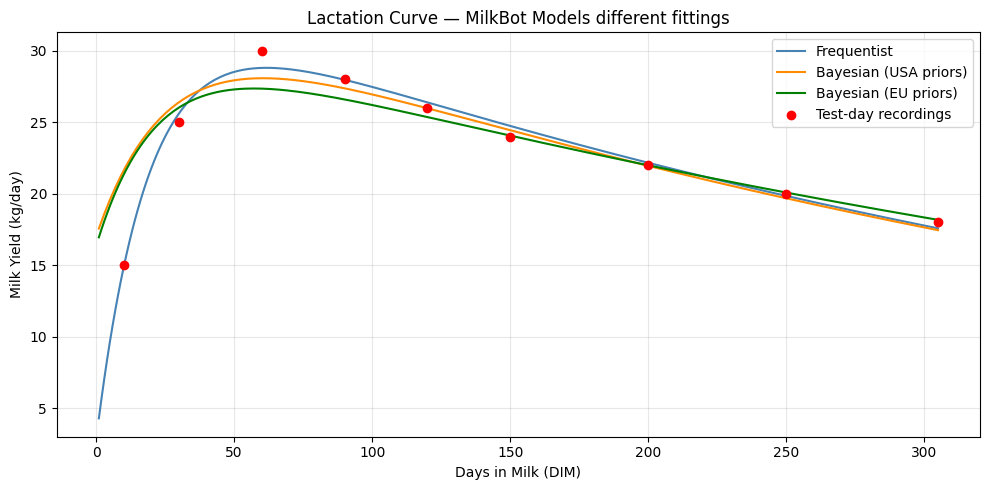

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(dim_predicted, fit, label="Frequentist", color="steelblue")
plt.plot(dim_predicted, mb_bay_usa, label="Bayesian (USA priors)", color="darkorange")
plt.plot(dim_predicted, mb_bay_eu, label="Bayesian (EU priors)", color="green")
plt.scatter(
    sample_data["dim"],
    sample_data["milkrecordings"],
    color="red",
    zorder=5,
    label="Test-day recordings",
)
plt.xlabel("Days in Milk (DIM)")
plt.ylabel("Milk Yield (kg/day)")
plt.title("Lactation Curve — MilkBot Models different fittings")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Calculate lactation curve characteristics 

Instead of getting the full curve, you can ask for a single summary statistic:

| Characteristic | Description |
|----------------|-------------|
| `time_to_peak` | Day in milk at which peak yield occurs |
| `peak_yield` | Maximum daily milk yield (kg) |
| `cumulative_milk_yield` | Total milk produced over the lactation (kg) |
| `persistency` | Rate of decline after peak |

This function fits the requested model (frequentist or Bayesian via MilkBot), retrieves model parameters, and evaluates the requested characteristic using the symbolic expression (if available), falling back to numeric methods when needed. There are four characteristics that can be calculated: 'time_to_peak', 'peak_yield', 'cumulative_milk_yield', 'persistency'.

In [32]:
# calculate time to peak using the frequentist fit wood model 
time_to_peak = calculate_characteristic(dim, milk_recording, model = 'wood', characteristic="time_to_peak")

print(f"Estimated time to peak (DIM): {time_to_peak:.2f}")

# calculate cumulative milk yield over 305 days using the frequentist fit MilkBot model 
cumulative_milk = calculate_characteristic(dim, milk_recording, model = 'milkbot', characteristic="cumulative_milk_yield")
print(f"Estimated cumulative milk yield over 305 days: {cumulative_milk:.2f} kg")

# calculate peak yield with the Bayesian fit MilkBot model:
peak_yield = calculate_characteristic(dim, milk_recording, model = 'milkbot', fitting = 'bayesian', characteristic='peak_yield', key = key, parity = 3, continent = 'USA', breed = 'J')
print(f"Estimated peak yield (kg): {peak_yield}")

Estimated time to peak (DIM): 84.60
Estimated cumulative milk yield over 305 days: 7041.66 kg
Estimated peak yield (kg): 27.482367658237653


### Calculate persistency 

In the literature you can find different definitions for persistency. For instance the Wood and MilkBot model have their own default persistency function as defined in their original papers. You can chose to use these functions by setting persistency_method = 'literature'. The default method is to calculate the average downward slope of the lactation curve from the peak to the end of lactation. This is dependent on the set lactation length, whereby 305 is the default, persistency_method = 'max' will give the average slope until the end of lactation (based on the maximal dim value provided) or lactation_length = (fill in your own integer) can set the value on your desired lactation length. 

In [41]:
#Based on the literature 
persistency_literature = cumulative_milk = calculate_characteristic(dim, milk_recording, model = 'milkbot', characteristic="persistency", persistency_method = 'literature')
print(f"The persistency according to the frequentist fitted MilkBot model with the definition of the literature is: {persistency_literature}")

#Based on the average slope: 
persistency_slope = cumulative_milk = calculate_characteristic(dim, milk_recording, model = 'milkbot', characteristic="persistency", persistency_method = 'derived', lactation_length = 305)
print(f"The persistency based on the average slope is in a lactation of 305 days: {persistency_slope}")

#Based on a shorter lactation, e.g. lactation_length =270
persistency_slope_short = cumulative_milk = calculate_characteristic(dim, milk_recording, model = 'milkbot', characteristic="persistency", persistency_method = 'derived', lactation_length = 270)
print(f"The persistency based on the average slope is in a lactation of 270 days: {persistency_slope_short}")

#Based on Bayesian fitting 
persistency_bay = cumulative_milk = calculate_characteristic(dim, milk_recording, model = 'milkbot', characteristic="persistency", fitting = 'bayesian', key = key, persistency_method = 'derived', lactation_length = 305)
print(f"The persistency based on the average slope, of a bayesian fitted curve: {persistency_bay}")

The persistency according to the frequentist fitted MilkBot model with the definition of the literature is: 313.836966039821
The persistency based on the average slope is in a lactation of 305 days: -0.046190024955026034
The persistency based on the average slope is in a lactation of 270 days: -0.047171551178477975
The persistency based on the average slope, of a bayesian fitted curve: -0.04336698785726349


---

## Direct Model Prediction 

If you already **know** the model parameters, you can get
predictions directly without fitting. This is useful when you have parameters from
a previous analysis or from the literature.

As an example 
The MilkBot model: `y(t) = a * (1 - exp((c - t) / b) / 2) * exp(-d * t)`

| Parameter | Meaning |
|-----------|--------|
| `a` | Scale — overall production level (kg) |
| `b` | Ramp — rate of rise in early lactation |
| `c` | Offset — time correction for calving |
| `d` | Decay — rate of exponential decline |


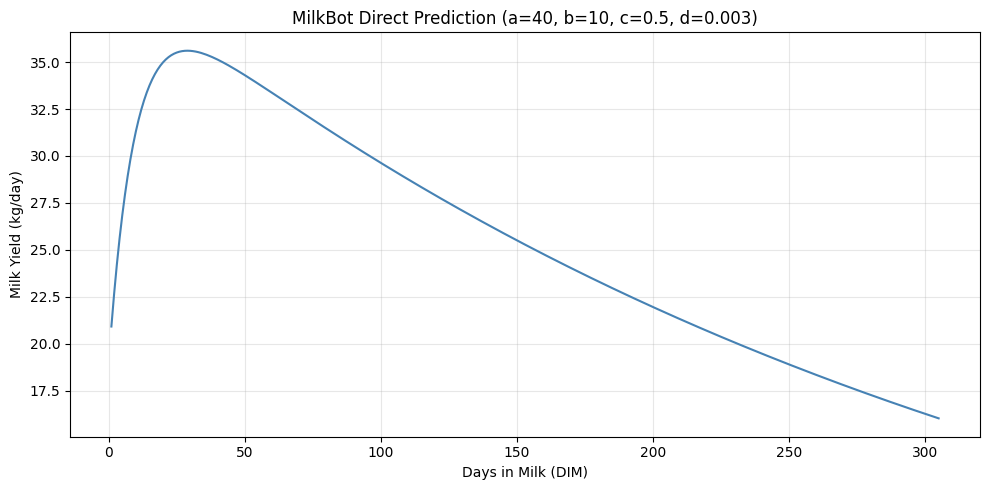

In [ ]:
#define parameters as floats:
a = 40
b = 10
c = 0.5
d = 0.003

milkbot_fit = []
for t in range(1,306): 
    milkbot_data_point = milkbot_model(t, a, b, c, d)
    milkbot_fit.append(milkbot_data_point)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 306), milkbot_fit, color="steelblue")
plt.xlabel("Days in Milk (DIM)")
plt.ylabel("Milk Yield (kg/day)")
plt.title(f"MilkBot Direct Prediction (a={a}, b={b}, c={c}, d={d})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This also works for many other lactation curve models. Take for instance the Dijkstra model.


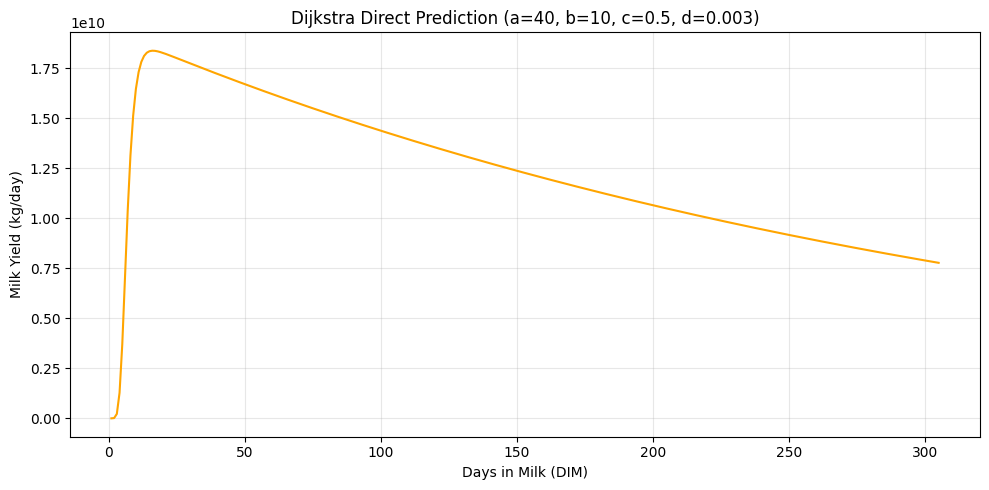

In [53]:
#define parameters as floats:
a = 40
b = 10
c = 0.5
d = 0.003

dijkstra_fit = []
for t in range(1,306): 
    dijkstra_data_point = dijkstra_model(t, a, b, c, d)
    dijkstra_fit.append(dijkstra_data_point)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 306), dijkstra_fit, color="orange")
plt.xlabel("Days in Milk (DIM)")
plt.ylabel("Milk Yield (kg/day)")
plt.title(f"Dijkstra Direct Prediction (a={a}, b={b}, c={c}, d={d})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Find the algabraic expression for a lactation curve characteristic 

The package also facilitates the extraction of functions for the calculation of characteristics as symbolic expressions for many models. We will give some examples here, but it can be applied to all of the following models: 'milkbot', 'wood', 'wilmink', 'ali_schaeffer', 'fischer', 'brody', 'sikka', 'nelder', 'dhanoa', 'emmans', 'hayashi', 'rook', 'dijkstra', 'prasad'.

In [ ]:
peak_yield = lactation_curve_characteristic_function(model = 'wood', characteristic = 'peak_yield')
print(f"The symbolic expresion to find the peak yield of the wood model is: {peak_yield[0]}")

time_to_peak = lactation_curve_characteristic_function(model = 'emmans', characteristic = 'time_to_peak')
print(f"The symbolic expresion to find the time to peak expression of the emmans model is: {time_to_peak[0]}")


The symbolic expresion to find the peak yield of the wood model is: a*(b*exp(-1)/c)**b
The symbolic expresion to find the time to peak expression of the emmans model is: log(b*exp(d)/c)/b


---

## ICAR Test Interval Method

The **ICAR Test Interval Method** calculates the total 305-day milk yield using the
trapezoidal rule — a standard method recognized by the International Committee for
Animal Recording (ICAR). It does **not** fit a mathematical model; instead, it
interpolates between test days.

### Single lactation

In [68]:
one_lactation = test_interval_method(sample_df, days_in_milk_col= 'dim', milking_yield_col= 'milkrecordings')

print(f"the cumulative milk yield based on the test interval method is: {one_lactation}")

the cumulative milk yield based on the test interval method is:    TestId  Total305Yield
0       1         7068.0


### Multiple lactations

You can process multiple animals/lactations in a single request by providing `test_ids`.

In [71]:
multi_request = {
    "dim": [10, 30, 60, 90, 120, 10, 30, 60, 90, 120],
    "milkrecordings": [15.0, 25.0, 30.0, 28.0, 26.0, 20.0, 30.0, 35.0, 32.0, 28.0],
    "test_ids": ["cow_A", "cow_A", "cow_A", "cow_A", "cow_A",
                 "cow_B", "cow_B", "cow_B", "cow_B", "cow_B"],
}

#convert to pandas
multi_request_pd = pd.DataFrame(multi_request)

result = test_interval_method(multi_request_pd, days_in_milk_col= 'dim', milking_yield_col= 'milkrecordings', test_id_col = 'test_ids')

print("Multiple lactation results:")
print(result)

Multiple lactation results:
  TestId  Total305Yield
0  cow_A         7891.0
1  cow_B         8788.0


## Using `help()` to Explore the Package

You can inspect function documentation directly in Python.


In [35]:
# Get the model function and parameter descriptions
from lactationcurve.characteristics import persistency_fitted_curve


help(milkbot_model)

# Find out about all potential function parameters
help(calculate_characteristic)

# Understand how a function works
help(persistency_fitted_curve)

Help on function milkbot_model in module lactationcurve.fitting.lactation_curve_fitting:

milkbot_model(t, a, b, c, d)
    MilkBot lactation curve model.

    Args:
        t: Time since calving in days (DIM), scalar or array-like.
        a: Scale; overall level of milk production.
        b: Ramp; governs the rate of rise in early lactation.
        c: Offset; small (usually minor) correction around the theoretical start of lactation.
        d: Decay; exponential decline rate, evident in late lactation.

    Returns:
        Predicted milk yield at `t` (same shape as `t`).

    Notes:
        Formula: `y(t) = a * (1 - exp((c - t) / b) / 2) * exp(-d * t)`.

Help on function calculate_characteristic in module lactationcurve.characteristics.lactation_curve_characteristics:

calculate_characteristic(dim, milkrecordings, model='wood', characteristic='cumulative_milk_yield', fitting='frequentist', key=None, parity=3, breed='H', continent='USA', persistency_method='derived', lactation_leng

##  Summary

In this tutorial you learned how to:

- Install and import `lactationcurve`
- Fit lactation curves using frequentist methods
- Configure and use a MilkBot API key for Bayesian fitting
- Calculate lactation curve characteristics 
- Find the algabraic expression for a lactation curve characteristic 
- Apply the test interval method to calculate cumulative milk yield
- Use `help()` to explore function documentation

You are now ready to apply lactation curve fitting to your own datasets. Keep in mind that the package has more functionalities then just the ones explaned in this tutorial. We encourage you to read through our documentation. 

### Further reading

- **`lactationcurve` package docs:** see https://bovi-analytics.github.io/lactation_curve_core/lactationcurve.html

### Api fitting 

Also check out our fitting api's that make using the package even easier! [Example notebook](notebooks/api_tutorial.ipynb) 